<a href="https://colab.research.google.com/github/shanizu/FLUORA/blob/main/FLUORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


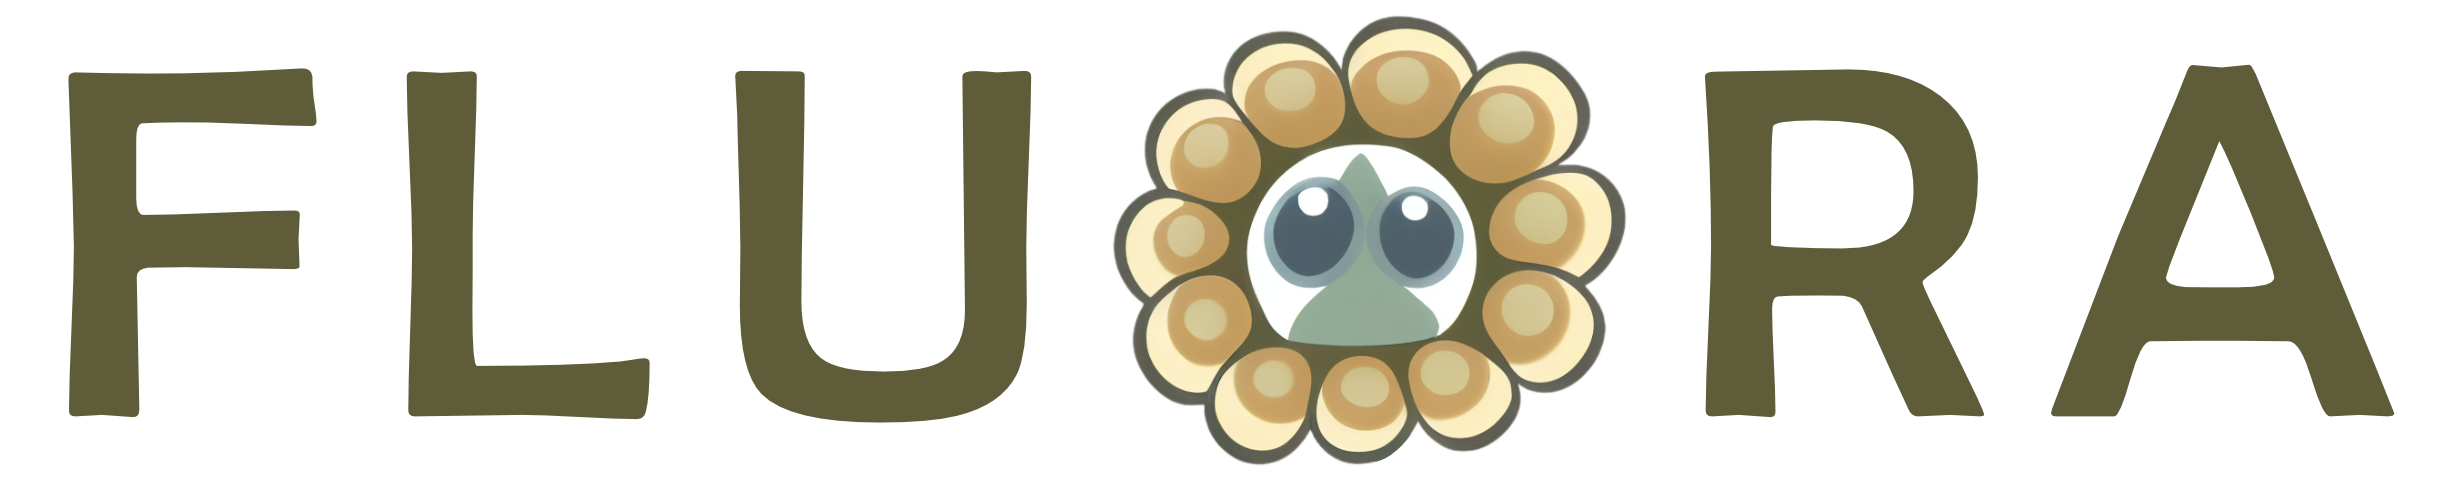
#**Cloud-based Fluorescent Cell Labeling and Analysis with Google Colab**
This Google Colab notebook provides an easy-to-use and accessible interface for the FLUORA software, a powerful tool designed for labeling and analyzing fluorescent cells in time-series microscopy images. With seamless integration of Cellpose-generated segmentation masks, this notebook enables both novice and advanced users to effectively process and analyze their data in a cloud-based environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#@markdown **Run this code block to import required dependencies and set up the program.**

# Imports

import math
import os
import sys
from collections import deque
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from tensorflow import get_logger, keras
from tqdm import tqdm

from keras.callbacks import EarlyStopping

get_logger().setLevel('ERROR')

# Define Functions and Classes

## Cell Similarity Metrics
def calculate_iou(cell1: int, frame1: np.ndarray, cell2: int, frame2: np.ndarray):
    """
    Calculates the Intersection over Union (IoU) of two cells in two frames.

    Args:
        cell1: The ID of the first cell to compare.
        frame1: A numpy ndarray representing the first frame.
        cell2: The ID of the second cell to compare.
        frame2: A numpy ndarray representing the second frame.

    Returns:
        The IoU of the two cells, as a float between 0 and 1.

    Raises:
        ValueError: If either cell ID is zero (which represents the background).
    """
    if cell1 != 0 and cell2 != 0:
        mask1 = frame1 == cell1
        mask2 = frame2 == cell2
        intersection = np.logical_and(mask1, mask2).sum()
        union = np.logical_or(mask1, mask2).sum()
        iou = intersection / union
    else:
        raise ValueError("Both cells must have non-zero IDs")
    return iou

def cosine_similarity(vec1, vec2):
    """
    Computes the cosine similarity between two vectors.
    
    Args:
        vec1: np.array, the first vector
        vec2: np.array, the second vector
    Returns:
        float, the cosine similarity between vec1 and vec2
    """
    dot_product = np.dot(np.squeeze(vec1), np.squeeze(vec2))
    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    similarity = dot_product / (vec1_norm * vec2_norm)
    return similarity

## Image Processing
def read_multiframe_tif(filename: str,
                         channel_selection: List[int]=[1]) -> list[np.ndarray]:
    """
    Reads a multi-frame tif file and returns a list of ndarrays of frames
    for the selected channels.

    Args:
        filename: The name of the tif file to read.
        channel_selection: A list of binary values (0 or 1), where the length
            is equal to the number of channels, and each value indicates whether
            the corresponding channel should be extracted (1) or not (0).
            (Default  [1], no channels)

    Returns:
        A list of numpy ndarrays containing the frames for the selected channels.
        The frames are in order of channel selected, then frame number.
    """
    img = Image.open(filename)
    n_frames_total = img.n_frames
    n_channels = len(channel_selection)

    selected_frames = []

    for channel, is_selected in enumerate(channel_selection):
        if is_selected:
            channel_frames = []
            for i in range(channel, n_frames_total, n_channels):
                img.seek(i)
                channel_frames.append(np.array(img))
            selected_frames.extend(np.array(channel_frames))
    return selected_frames

def process_image(img_data, size=(28, 28)) -> np.ndarray:
    """
    Rescale, convert to grayscale, pad, and normalize an input image.

    Args:
        img_data (numpy.array): Input image as a numpy array.
        size (tuple, optional): Desired output size (width, height). Default: (28, 28).

    Returns:
        np.ndarray of processed and rescaled image with pixel values in range [0, 1].
    """
    # Normalize the image to the range [0, 1]
    min_val, max_val = np.min(img_data), np.max(img_data)
    normalized_image = (img_data - min_val) / (max_val - min_val)

    # Convert image to PIL Image format, to grayscale, and pad to the desired size
    img = Image.fromarray((normalized_image * 255).astype(np.uint8))
    img = img.convert('L')
    img = ImageOps.pad(img, size, method=Image.NEAREST)

    # Convert the image back to a numpy array
    img_array = np.array(img) / 255
    
    del min_val, max_val, normalized_image, img
    return img_array

def extract_cells(images_path: str, masks_path: str,
                  channel_selection: list[int]=[1]) -> Dict[str, np.ndarray]:
    """
    Extracts individual cell images from a multi-frame image and mask file, and writes
    them to a dictionary.

    Args:
        images_path (str): The path to the multi-frame image file.
        masks_path (str): The path to the multi-frame mask file.
        channel_selection: A list or tuple of binary values (0 or 1), where
            the length is equal to the number of channels, and each value
            indicates whether the corresponding channel should be extracted (1)
            or not (0). (Default  [1], no channels)

    Returns:
        dict: A dictionary containing processed cell images with keys in the format
        "frame_{frame_idx}_cell_{cell_id}".
    """
    image_frames = read_multiframe_tif(images_path, channel_selection)
    mask_frames = read_multiframe_tif(masks_path)

    cell_dict = {}
    for frame_idx, (image_frame, mask_frame) in enumerate(
        tqdm(zip(image_frames, mask_frames),
             total=len(image_frames),
             desc='Extracting cells',
             unit="frame")):
        cell_ids = set(mask_frame.flatten())
        if 0 in cell_ids:
            cell_ids.remove(0)

        for cell_id in cell_ids:
            cell_coords = (mask_frame == cell_id).nonzero()
            x_min, x_max = min(cell_coords[0]), max(cell_coords[0])
            y_min, y_max = min(cell_coords[1]), max(cell_coords[1])

            cell_mask = (mask_frame == cell_id)
            clipped_image = image_frame * cell_mask
            cell_image = clipped_image[x_min:x_max+1, y_min:y_max+1]
            processed_img = process_image(cell_image)

            cell_dict[f"frame_{frame_idx}_cell_{cell_id}"] = processed_img
    del image_frames, mask_frames
    return cell_dict

## Cell Lineage Management
class Cell:
    def __init__(self, cell_id: int, lineage_id: int, frame: int, x: float, y: float):
        """
        Initializes a new Cell object.

        Args:
            cell_id: The unique ID of the cell.
            lineage_id: The ID of the cell's lineage.
            frame: The frame index in which the cell first appears.
            x: The x-coordinate of the cell's centroid.
            y: The y-coordinate of the cell's centroid.

        Returns:
            None
        """
        self.cell_id = cell_id
        self.lineage_id = lineage_id
        self.frame = frame
        self.x = x
        self.y = y
    
    def __repr__(self):
        return (
            f'Cell {self.cell_id} from Lineage {self.lineage_id}',
            f'at Frame {self.frame} with centroid ({self.x}, {self.y})'
            )

class Library:
    def __init__(self, init_mask: np.ndarray, df: pd.DataFrame):
        """
        Initializes a new Library object and populates it with Cell objects based on an 
        initial mask and DataFrame.

        Args:
            init_mask: A numpy ndarray representing the initial cell mask.
            df: A pandas DataFrame containing cell information.

        Returns:
            None
        """
        self.lineages = []
        for cell in np.unique(init_mask):
            if cell != 0:
                cell_info = df[(df['Frame']==0) & (df['ROI']==(cell-1))]
                x = cell_info['x'].iloc[0]
                y = cell_info['y'].iloc[0]
                new_cell = Cell(cell, cell, 0, x, y)
                self.add_cell(new_cell)
        del cell, cell_info, x, y, new_cell

    def add_cell(self, cell: Cell) -> None:
        """
        Adds a Cell object to the Library object.

        Args:
            cell: A Cell object to be added to the Library.

        Returns:
            None
        """
        if cell.lineage_id > len(self.lineages):
            self.lineages.extend(
                deque() for _ in range(cell.lineage_id - len(self.lineages)))
        self.lineages[cell.lineage_id-1].append(cell)

    def to_dataframe(self) -> pd.DataFrame:
        """
        Converts the Library object to a pandas DataFrame.

        Returns:
            A pandas DataFrame containing information about each Cell object
            in the Library.
        """
        data = []
        for i, lineage in enumerate(self.lineages):
            for cell in lineage:
                data.append({
                    'cell_id': cell.cell_id,
                    'lineage_id': i+1,
                    'Frame': cell.frame,
                    'x': cell.x,
                    'y': cell.y
                    })
        return pd.DataFrame(data)
    
    def all_recent(self) -> List[Dict[str, Union[int, float]]]:
        """
        Returns a list of dictionaries representing the most recent Cell object
        in each lineage.

        Returns:
            A list of dictionaries, where each dictionary represents the most recent
            Cell object in a lineage. Each dictionary has the following keys:
            'cell_id', 'lineage_id', 'frame', 'x', 'y', with corresponding values for
            each attribute of the Cell object.
        """
        recent_cells = []
        for i, lineage in enumerate(self.lineages):
            if len(lineage) > 0:
                cell = lineage[-1]
                recent_cells.append({
                    'cell_id': cell.cell_id,
                    'lineage_id': i + 1,
                    'frame': cell.frame,
                    'x': cell.x,
                    'y': cell.y
                    })
        return recent_cells

    def is_recent_cell(self, frame: int, cell_id: int) -> int:
        """
        Checks if a cell is a recent cell based on the frame number and cell id.

        Args:
            frame: The frame number to check.
            cell_id: The cell id to check.

        Returns:
            The lineage number the cell was found in if it is a recent cell; else, -1.
        """
        for lineage_id, lineage in enumerate(self.lineages, start=1):
            if len(lineage) > 0:
                recent_cell = lineage[-1]
                if recent_cell.frame == frame and recent_cell.cell_id == cell_id:
                    return lineage_id
        return -1
    
    def identify_cells(self, current_frame: int, scores: List[Dict], 
                    iou_weights=0.6, visual_weights=0.4) -> None:
        """
        Find the best matching cell based on IoU and visual scores, and add it to the
        Lineage Library.

        Args:
            current_frame (int): Frame number of potential matching cells.
            cell (dict): Reference cell with its features.
            scores (list of dict): Potential matching cells with their
                features and scores.

        Returns:
            None
        """
        if not scores:
            return

        visual_scores = np.array([score['visual_score'] for score in scores])
        min_vis_score = np.min(visual_scores)
        max_vis_score = np.max(visual_scores)
        vis_score_range = max_vis_score - min_vis_score

        if vis_score_range != 0:
            visual_scores = (visual_scores - min_vis_score) / vis_score_range
        else:
            visual_scores = np.ones_like(visual_scores)

        normalized_scores = (
            iou_weights * np.array([score['iou_score'] for score in scores]) +
            visual_weights * visual_scores
        )

        while scores:
            match_index = np.argmax(normalized_scores)
            
            matched_cell = Cell(
                cell_id = scores[match_index]['next_cell_id'],
                lineage_id = scores[match_index]['lineage_id'],
                frame = current_frame,
                x = scores[match_index]['next_cell_x'],
                y = scores[match_index]['next_cell_y']
                )
            self.add_cell(matched_cell)

            matched_cell_id = scores[match_index]['next_cell_id']

            cell_id_indices = [i for i, score in enumerate(scores)
                               if score['next_cell_id'] == matched_cell_id]
            scores = [score for score in scores 
                      if score['next_cell_id'] != matched_cell_id]
            normalized_scores = np.delete(normalized_scores, cell_id_indices)
    
    def remove_short_lineages(self, min_percent: float, total_frames: int) -> None:
            """
            Remove lineages that have been tracked for fewer frames than 
            min_percent/100*total_frames.

            Parameters:
            
                min_percent: float
                    Minimum percentage of total frames that a lineage must 
                    be tracked for in order to be kept.
                total_frames: int
                    Total number of frames in the video.

            Returns:

                None
            """
            min_frames = min_percent / 100 * total_frames
            self.lineages = [
                lineage for lineage in self.lineages if len(lineage) >= min_frames
                ]

In [16]:
#@title **Cell Labeling**
#@markdown Please provide the required input information below.
#@markdown **Run this block to save changes.**

imgs_path = "/content/drive/Shareddrives/H2O2/Tracking_Data/RFP_GFP_MIDDLE5.tif" #@param {type:"string"}
masks_path = "/content/drive/Shareddrives/H2O2/Tracking_Data/2022-11-10_EXP_MIDDLE5_1/segmentations/seg_RFP_GFP_MIDDLE5.tif" #@param {type:"string"}
info_path = "/content/drive/Shareddrives/H2O2/Tracking_Data/2022-11-10_EXP_MIDDLE5_1/2022-11-10_EXP_MIDDLE5_1.csv" #@param {type:"string"}
channel = "RFP" #@param {type:"string"}
search_radius = 100 #@param {type:"number"}
#@markdown **If you have run FLUORA on your data before and *have not made changes to the output* `_FLUORA` *folder generated by this pipeline*, check this box to reduce processing times:**
import_preprocessing = False #@param {type: "boolean"}

In [20]:
#@markdown **Run this block to run FLUORA and label the cells.**

### PART 1: Import data and Preprocessing######################################
print("IMPORTING DATA AND PREPROCESSING...")

# 1. Import data and check that paths are valid
if (os.path.exists(imgs_path) and os.path.exists(masks_path) and 
    os.path.exists(info_path)):
    masks = read_multiframe_tif(masks_path)
    info_df = pd.read_csv(info_path)
else:
    print('ERROR: Input data not found. Check path names.')
    sys.exit(0)

# 2. Pre-processing informational data (channel, centroid extraction)
df = info_df[['Frame', 'ROI']].copy()
df = df[info_df['Channel'] == channel]
centroids = (
    info_df['Centroid']
    .str.strip('()')
    .str.split(', ', expand=True)
    .astype(float)
    )
df[['x', 'y']] = centroids

# 3. Import or generate encoded cell vectors
folder_path, file_name_with_ext = os.path.split(imgs_path)
file_name, file_ext = os.path.splitext(file_name_with_ext)

new_folder_path = os.path.join(folder_path, file_name + '_FLUORA')
vectors_path = os.path.join(new_folder_path, 'encoded_cells.npz')
encoder_path = os.path.join(new_folder_path, 'cell_encoder.h5')

if import_preprocessing and (os.path.exists(new_folder_path)):
    if os.path.exists(vectors_path):
        pass
    else:
        print('ERROR: Preprocessed data not found.')
        sys.exit(0)
    with np.load(vectors_path) as data_read:
        cell_vectors = {key: data_read[key] for key in data_read.files}
    
    print("PREPROCESSED DATA IMPORTED.")
else:
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    # 4. Extract cells and generate cell imgs. (img name e.g., 'frame_0_cell_1')
    unique_channels = info_df['Channel'].unique().tolist()
    channel_list = [1 if channel == option else 0 for option in unique_channels]

    cell_dict = extract_cells(imgs_path, masks_path, channel_list)

    x_train = np.array(list(cell_dict.values()))
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_train, x_test = train_test_split(x_train, test_size=0.2, random_state=42)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    # 5. Train autoencoder on the single cell images, save encoder model
    encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(30, activation="relu"),
        ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="relu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
        ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(loss="binary_crossentropy",
                    optimizer='adam')
    autoencoder.fit(x_train, x_train, epochs=100, validation_data=[x_test, x_test],
                    callbacks=[early_stop], verbose=0) 
    del x_train, x_test

    # 6. Get latent vectors and save to file
    cell_names = np.array(list(cell_dict.keys()))
    cell_images = np.stack(list(cell_dict.values()), axis=0)

    cell_vectors = encoder.predict(cell_images, verbose=0)
    cell_vectors = dict(zip(cell_names, cell_vectors))
    np.savez(vectors_path, **cell_vectors)
    encoder.save(encoder_path)
    del cell_dict, cell_images

    print("PREPROCESSING COMPLETE.")

### PART 2: Frame-by-frame Pairwise Cell Labeling##############################
print("INITIATING FRAME-BY-FRAME CELL IDENTIFICATION...")

# Initialize library for tracking lineages
lib = Library(masks[0], df)

for i, mask in tqdm(enumerate(masks[1:]), total=len(masks)-1,
                    desc="Processing Frames", unit="frame"):
    current_frame = i + 1
    temp_df = df[df['Frame'] == current_frame]

    scores = []
    for recent_cell in lib.all_recent():
        curr_mask = masks[current_frame]
        prev_mask = masks[recent_cell['frame']]

        key = f'frame_{recent_cell["frame"]}_cell_{recent_cell["cell_id"]}'
        recent_vec = cell_vectors[key]

        new_cells = np.unique(curr_mask)[1:]
        new_cells = new_cells[new_cells != 0]

        recent_cell_coords = np.array([recent_cell['x'], recent_cell['y']])
        new_cell_coords = (
            temp_df[temp_df['ROI'].isin(new_cells - 1)][['x', 'y']].to_numpy()
            )
        distances = cdist(recent_cell_coords.reshape(1, -1), new_cell_coords)[0]
        new_cells = new_cells[distances < search_radius]

        for new_cell in new_cells:
            if lib.is_recent_cell(current_frame, new_cell) == -1:
                x_new, y_new = (
                    temp_df[temp_df['ROI'] == (new_cell - 1)].iloc[0][['x', 'y']]
                    )
                
                iou_score = calculate_iou(recent_cell['cell_id'], prev_mask, 
                                        new_cell, mask)

                if iou_score > 0:
                    key = f'frame_{current_frame}_cell_{new_cell}'
                    new_vec = cell_vectors[key]
                    visual_score = cosine_similarity(recent_vec, new_vec)

                    distance = math.sqrt(
                        (x_new - recent_cell['x'])**2 +
                        (y_new - recent_cell['y'])**2
                        )

                    scores.append({
                        'next_cell_id': new_cell,
                        'next_cell_x': x_new,
                        'next_cell_y': y_new,
                        'lineage_id': recent_cell['lineage_id'],
                        'iou_score': iou_score,
                        'visual_score': visual_score,
                        'distance': distance
                        })
    lib.identify_cells(current_frame, scores)
lib.remove_short_lineages(10, len(masks))

print("\nCELL IDENTIFICATION COMPLETE.")

### PART 3: Preview and Export Results#########################################

results = lib.to_dataframe()
results = results.rename(columns={'cell_id':'ROI', 'lineage_id':'Label'})
results['ROI'] -= 1

final_df = info_df.merge(results, on=['ROI', 'Frame'], how='left')
final_df.head(100)

IMPORTING DATA AND PREPROCESSING...


Extracting cells: 100%|██████████| 100/100 [00:42<00:00,  2.35frame/s]


PREPROCESSING COMPLETE.
INITIATING FRAME-BY-FRAME CELL IDENTIFICATION...


Processing Frames: 100%|██████████| 99/99 [01:44<00:00,  1.06s/frame]


CELL IDENTIFICATION COMPLETE.


,Unnamed: 0,Intensity,Centroid,BoundingBox,Area_BB,ROI,Frame,Channel,channel1,channel2,Well,Label,x,y
0,0,185.379710,"(16.383333333333333, 704.5297101449275)","(0, 683, 39, 730)",1833,0,0,RFP,RFP,GFP,MIDDLE5,1.0,16.383333,704.529710
1,1,237.746639,"(18.98862461220269, 967.858841778697)","(0, 942, 44, 997)",2420,1,0,RFP,RFP,GFP,MIDDLE5,2.0,18.988625,967.858842
2,2,143.254186,"(85.14746313421645, 1049.1449637590601)","(50, 1015, 122, 1087)",5184,2,0,RFP,RFP,GFP,MIDDLE5,3.0,85.147463,1049.144964
3,3,278.804209,"(106.5300396462336, 874.0414760597744)","(76, 835, 136, 909)",4440,3,0,RFP,RFP,GFP,MIDDLE5,4.0,106.530040,874.041476
4,4,284.023021,"(173.15440763615945, 242.1052779337451)","(133, 215, 213, 270)",4400,4,0,RFP,RFP,GFP,MIDDLE5,5.0,173.154408,242.105278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,135.761315,"(86.55385183816738, 1052.2817291705155)","(45, 1015, 133, 1098)",7304,2,3,RFP,RFP,GFP,MIDDLE5,3.0,86.553852,1052.281729
96,96,248.250196,"(117.09124183006536, 863.9207843137254)","(79, 824, 147, 900)",5168,3,3,RFP,RFP,GFP,MIDDLE5,4.0,117.091242,863.920784
97,97,213.862495,"(161.41542379046925, 236.60276464168788)","(116, 200, 209, 275)",6975,4,3,RFP,RFP,GFP,MIDDLE5,5.0,161.415424,236.602765
98,98,177.020358,"(185.25361491628615, 565.3032724505327)","(132, 523, 234, 619)",9792,5,3,RFP,RFP,GFP,MIDDLE5,6.0,185.253615,565.303272


In [ ]:
#@title **Preview Results**
#@markdown **Run this block to preview labels on your cell images.**